<a href="https://colab.research.google.com/github/ra1ph2/Vision-Transformer/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Libraries Imported

In [ ]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla K80


#### Model Architecture

##### Vision Transformer

In [ ]:
class Attention(nn.Module):
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
attention = Attention(embed_dim=4, heads=2, activation=None)
attention_lib = nn.MultiheadAttention(embed_dim=4, num_heads=2)
inp = torch.ones((1, 2, 4))
print(inp)
out, wts = attention(inp)
print(out)
print(wts)
out_lib, out_wts = attention_lib(inp.permute(1, 0, 2), inp.permute(1, 0, 2), inp.permute(1, 0, 2))
print(out_lib.permute(1, 0, 2))
print(out_wts)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
tensor([[[-0.0957, -0.3109,  1.3709,  0.4726],
         [-0.0957, -0.3109,  1.3709,  0.4726]]], grad_fn=<UnsafeViewBackward>)
tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<SoftmaxBackward>)
tensor([[[-0.1171,  0.3081,  0.2985, -0.0321],
         [-0.1171,  0.3081,  0.2985, -0.0321]]], grad_fn=<PermuteBackward>)
tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]]], grad_fn=<DivBackward0>)


In [ ]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [ ]:
ff = FeedForward(8, 1)
inp = torch.ones((1, 2, 8))
print(inp)
out = ff(inp)
print(out)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[-0.2281,  0.3137, -0.1605,  0.0162, -0.1546, -0.0090, -0.1936,
          -0.2936],
         [-0.1731,  0.3414, -0.1284,  0.0356, -0.1575, -0.0277, -0.1333,
          -0.2277]]], grad_fn=<AddBackward0>)


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
tb = TransformerBlock(8, 2)
inp = torch.ones((1, 2, 8))
print(inp)
out = tb(inp)
print(out)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[1.0726, 0.9965, 0.6630, 1.2136, 0.7329, 1.0218, 1.5265, 1.2960],
         [1.0499, 1.0092, 0.6646, 1.1485, 0.7814, 1.0534, 1.3679, 1.3247]]],
       grad_fn=<AddBackward0>)


In [ ]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
tb = TransformerBlock(8, 2)
trans = Transformer(8, 1, 2)
inp = torch.ones((1, 2, 8))
print(inp)
out = tb(inp)
print(out)
out = trans(inp)
print(out)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]])
tensor([[[0.2712, 1.2533, 0.8600, 1.0793, 0.9668, 0.7111, 1.3262, 0.5399],
         [0.8261, 1.2068, 1.2664, 0.7084, 0.6929, 0.9633, 1.8928, 1.1256]]],
       grad_fn=<AddBackward0>)
tensor([[[0.6467, 1.1435, 0.7156, 1.1247, 1.3399, 0.8775, 0.9435, 1.4318],
         [0.7944, 0.8476, 0.4949, 1.2257, 1.5716, 0.6842, 0.9751, 1.5345]]],
       grad_fn=<AddBackward0>)


In [ ]:
# Not Exactly Same as Paper | Check if Dropout should be used here
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, embed_dim) | SoftMaxed along the last dimension
        return out

In [ ]:
ch = ClassificationHead(8, 2)
inp = torch.ones((2, 8))
print(inp)
out = ch(inp)
print(out)

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0781, 0.3392],
        [0.0781, 0.3392]], grad_fn=<AddmmBackward>)


In [ ]:
#TODO: Remove to.device from class_token
class VisionTransformer(nn.Module):
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [ ]:
vit = VisionTransformer(2, 3, 8, 2, 2).to(device)
inp = torch.ones((2, 3, 2, 2)).to(device)
print(inp)
class_out, out = vit(inp)
print(class_out)
print(class_out.shape)
print(out)
print(out.shape)

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]],


        [[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]]], device='cuda:0')
tensor([[0.2645, 0.1355],
        [0.1855, 0.0469]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([2, 2])
tensor([[[-0.5125, -1.1956,  1.2946, -0.8469,  1.2595,  2.0988, -1.4771,
          -0.6159],
         [-2.5190, -1.3817,  0.7105,  1.0861,  0.3958, -1.8753, -0.7575,
          -0.8722]],

        [[ 0.0070, -0.8209,  1.7141, -1.0750,  0.8318,  1.7269, -1.6796,
          -0.2039],
         [-2.0373, -0.7573,  0.7090,  0.6679, -0.0043, -2.3334, -0.2896,
          -1.3234]]], device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([2, 2, 8])


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet

In [ ]:
class ResidualBlockSmall(nn.Module):
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetSmall(nn.Module):
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [ ]:
class ResidualBlockLarge(nn.Module):
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetLarge(nn.Module):
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet34(input_channels, classes):
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [ ]:
def ResNet50(input_channels, classes):
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading

In [ ]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):

    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [ ]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):

    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation

In [ ]:
lr = 0.003
batch_size = 128
num_workers = 2
shuffle = True
patch_size = 14
image_sz = 32
# max_len = ((image_sz//patch_size) * (image_sz//patch_size)) + 1 # +1 for the class token
max_len = 50 # All sequences must be less than 50 including class token
embed_dim = 512
classes = 10
layers = 12
resnet_features_channels = 64
heads = 16
epochs = 100

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [ ]:
def evaluation(model, dataloader, criterion, resnet_features=None):

    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

##### Model - Vision Transformer

In [ ]:
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    heads=heads).to(device)

In [ ]:
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

##### Model - ResNet50 or ResNet34

In [ ]:
model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

In [ ]:
model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

##### Model Training

In [ ]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoint.pt') 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 1 - acc: 0.2481 - loss : 2.0071



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.3144 - test loss : 1.8772



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 2 - acc: 0.3245 - loss : 1.8229



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.3771 - test loss : 1.6895



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 3 - acc: 0.3649 - loss : 1.7268



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.3988 - test loss : 1.6615



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 4 - acc: 0.3876 - loss : 1.6763



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4257 - test loss : 1.5767



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 5 - acc: 0.4048 - loss : 1.6308



100%|██████████| 40/40 [00:03<00:00, 12.02it/s]


test acc: 0.4222 - test loss : 1.5938



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 6 - acc: 0.4204 - loss : 1.5891



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4480 - test loss : 1.5136



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 7 - acc: 0.4341 - loss : 1.5624



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4408 - test loss : 1.5571



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 8 - acc: 0.4442 - loss : 1.5299



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4599 - test loss : 1.4927



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 9 - acc: 0.4502 - loss : 1.5126



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4687 - test loss : 1.4788



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 10 - acc: 0.4558 - loss : 1.4989



100%|██████████| 40/40 [00:03<00:00, 11.94it/s]


test acc: 0.4693 - test loss : 1.4574



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 11 - acc: 0.4637 - loss : 1.4800



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4648 - test loss : 1.4639



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 12 - acc: 0.4724 - loss : 1.4610



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4728 - test loss : 1.4683



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 13 - acc: 0.4797 - loss : 1.4450



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4868 - test loss : 1.4265



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 14 - acc: 0.4828 - loss : 1.4335



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4829 - test loss : 1.4398



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 15 - acc: 0.4884 - loss : 1.4190



100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


test acc: 0.4795 - test loss : 1.4257



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 16 - acc: 0.4888 - loss : 1.4104



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4842 - test loss : 1.4336



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 17 - acc: 0.4970 - loss : 1.3992



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4832 - test loss : 1.4345



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 18 - acc: 0.5001 - loss : 1.3883



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4877 - test loss : 1.4226



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 19 - acc: 0.5024 - loss : 1.3843



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4955 - test loss : 1.4074



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 20 - acc: 0.5083 - loss : 1.3705



100%|██████████| 40/40 [00:03<00:00, 12.12it/s]


test acc: 0.4965 - test loss : 1.4205



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 21 - acc: 0.5086 - loss : 1.3663



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4938 - test loss : 1.4078



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 22 - acc: 0.5132 - loss : 1.3536



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.4981 - test loss : 1.4013



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 23 - acc: 0.5151 - loss : 1.3484



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5133 - test loss : 1.3661



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 24 - acc: 0.5181 - loss : 1.3410



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5123 - test loss : 1.3658



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 25 - acc: 0.5204 - loss : 1.3323



100%|██████████| 40/40 [00:03<00:00, 12.06it/s]


test acc: 0.5117 - test loss : 1.3736



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 26 - acc: 0.5239 - loss : 1.3278



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5052 - test loss : 1.3864



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 27 - acc: 0.5262 - loss : 1.3199



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5070 - test loss : 1.3702



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 28 - acc: 0.5295 - loss : 1.3112



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5063 - test loss : 1.3779



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 29 - acc: 0.5324 - loss : 1.3067



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5009 - test loss : 1.3847



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 30 - acc: 0.5349 - loss : 1.3004



100%|██████████| 40/40 [00:03<00:00, 12.18it/s]


test acc: 0.5045 - test loss : 1.3833



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 31 - acc: 0.5399 - loss : 1.2877



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5044 - test loss : 1.3856



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 32 - acc: 0.5409 - loss : 1.2825



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5135 - test loss : 1.3639



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 33 - acc: 0.5409 - loss : 1.2849



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5066 - test loss : 1.3712



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 34 - acc: 0.5453 - loss : 1.2711



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5106 - test loss : 1.3718



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 35 - acc: 0.5444 - loss : 1.2718



100%|██████████| 40/40 [00:03<00:00, 12.10it/s]


test acc: 0.5202 - test loss : 1.3538



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 36 - acc: 0.5526 - loss : 1.2595



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5140 - test loss : 1.3692



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 37 - acc: 0.5484 - loss : 1.2547



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5143 - test loss : 1.3487



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 38 - acc: 0.5537 - loss : 1.2473



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5252 - test loss : 1.3237



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 39 - acc: 0.5577 - loss : 1.2390



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5173 - test loss : 1.3621



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 40 - acc: 0.5579 - loss : 1.2380



100%|██████████| 40/40 [00:03<00:00, 12.10it/s]


test acc: 0.5245 - test loss : 1.3365



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 41 - acc: 0.5584 - loss : 1.2295



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5114 - test loss : 1.3845



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 42 - acc: 0.5608 - loss : 1.2292



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5271 - test loss : 1.3168



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 43 - acc: 0.5632 - loss : 1.2271



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5284 - test loss : 1.3296



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 44 - acc: 0.5653 - loss : 1.2141



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5240 - test loss : 1.3353



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 45 - acc: 0.5658 - loss : 1.2169



100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


test acc: 0.5287 - test loss : 1.3359



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 46 - acc: 0.5684 - loss : 1.2044



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5326 - test loss : 1.3354



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 47 - acc: 0.5706 - loss : 1.2048



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5327 - test loss : 1.3231



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 48 - acc: 0.5741 - loss : 1.1991



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5197 - test loss : 1.3547



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 49 - acc: 0.5767 - loss : 1.1923



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5423 - test loss : 1.3000



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 50 - acc: 0.5749 - loss : 1.1885



100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


test acc: 0.5384 - test loss : 1.2984



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 51 - acc: 0.5782 - loss : 1.1820



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5375 - test loss : 1.3095



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 52 - acc: 0.5783 - loss : 1.1795



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5424 - test loss : 1.2999



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 53 - acc: 0.5794 - loss : 1.1759



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5445 - test loss : 1.2935



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 54 - acc: 0.5797 - loss : 1.1742



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5396 - test loss : 1.2967



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 55 - acc: 0.5852 - loss : 1.1603



100%|██████████| 40/40 [00:03<00:00, 11.99it/s]


test acc: 0.5287 - test loss : 1.3247



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 56 - acc: 0.5846 - loss : 1.1733



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5376 - test loss : 1.2984



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 57 - acc: 0.5871 - loss : 1.1569



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5474 - test loss : 1.2759



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 58 - acc: 0.5884 - loss : 1.1584



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5375 - test loss : 1.3031



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 59 - acc: 0.5915 - loss : 1.1506



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5399 - test loss : 1.3001



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 60 - acc: 0.5911 - loss : 1.1510



100%|██████████| 40/40 [00:03<00:00, 12.10it/s]


test acc: 0.5450 - test loss : 1.2872



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 61 - acc: 0.5941 - loss : 1.1401



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5469 - test loss : 1.2951



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 62 - acc: 0.5955 - loss : 1.1340



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5417 - test loss : 1.2932



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 63 - acc: 0.5935 - loss : 1.1370



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5409 - test loss : 1.2911



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 64 - acc: 0.5983 - loss : 1.1324



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5407 - test loss : 1.3019



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 65 - acc: 0.5981 - loss : 1.1294



100%|██████████| 40/40 [00:03<00:00, 11.98it/s]


test acc: 0.5470 - test loss : 1.2924



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 66 - acc: 0.6006 - loss : 1.1271



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5315 - test loss : 1.3300



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 67 - acc: 0.6022 - loss : 1.1207



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5462 - test loss : 1.2859



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 68 - acc: 0.6080 - loss : 1.1087



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5450 - test loss : 1.2770



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 69 - acc: 0.6023 - loss : 1.1124



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5527 - test loss : 1.2739



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 70 - acc: 0.6046 - loss : 1.1052



100%|██████████| 40/40 [00:03<00:00, 12.09it/s]


test acc: 0.5525 - test loss : 1.2819



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 71 - acc: 0.6059 - loss : 1.1110



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5436 - test loss : 1.3066



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 72 - acc: 0.6080 - loss : 1.0987



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5532 - test loss : 1.2785



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 73 - acc: 0.6068 - loss : 1.1010



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5517 - test loss : 1.2748



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 74 - acc: 0.6092 - loss : 1.0995



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5454 - test loss : 1.2961



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 75 - acc: 0.6120 - loss : 1.0884



100%|██████████| 40/40 [00:03<00:00, 12.03it/s]


test acc: 0.5514 - test loss : 1.2718



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 76 - acc: 0.6114 - loss : 1.0937



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5452 - test loss : 1.3018



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 77 - acc: 0.6139 - loss : 1.0873



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5507 - test loss : 1.2787



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 78 - acc: 0.6119 - loss : 1.0862



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5535 - test loss : 1.2730



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 79 - acc: 0.6161 - loss : 1.0826



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5479 - test loss : 1.2770



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 80 - acc: 0.6164 - loss : 1.0785



100%|██████████| 40/40 [00:03<00:00, 12.12it/s]


test acc: 0.5455 - test loss : 1.2997



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 81 - acc: 0.6191 - loss : 1.0734



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5563 - test loss : 1.2854



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 82 - acc: 0.6187 - loss : 1.0762



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5559 - test loss : 1.2789



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 83 - acc: 0.6248 - loss : 1.0579



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5540 - test loss : 1.2920



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 84 - acc: 0.6228 - loss : 1.0653



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5623 - test loss : 1.2757



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 85 - acc: 0.6208 - loss : 1.0642



100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


test acc: 0.5535 - test loss : 1.2747



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 86 - acc: 0.6254 - loss : 1.0595



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5591 - test loss : 1.2709



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 87 - acc: 0.6243 - loss : 1.0529



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5625 - test loss : 1.2684



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 88 - acc: 0.6226 - loss : 1.0606



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5565 - test loss : 1.2680



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 89 - acc: 0.6329 - loss : 1.0401



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5653 - test loss : 1.2551



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 90 - acc: 0.6246 - loss : 1.0522



100%|██████████| 40/40 [00:03<00:00, 12.15it/s]


test acc: 0.5645 - test loss : 1.2681



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 91 - acc: 0.6306 - loss : 1.0413



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5529 - test loss : 1.2946



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 92 - acc: 0.6300 - loss : 1.0421



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5630 - test loss : 1.2682



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 93 - acc: 0.6313 - loss : 1.0396



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5592 - test loss : 1.2646



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 94 - acc: 0.6289 - loss : 1.0383



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5662 - test loss : 1.2532



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 95 - acc: 0.6342 - loss : 1.0303



100%|██████████| 40/40 [00:03<00:00, 12.17it/s]


test acc: 0.5653 - test loss : 1.2722



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 96 - acc: 0.6358 - loss : 1.0274



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5660 - test loss : 1.2416



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 97 - acc: 0.6315 - loss : 1.0280



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5557 - test loss : 1.3095



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 98 - acc: 0.6358 - loss : 1.0238



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5645 - test loss : 1.2652



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 99 - acc: 0.6382 - loss : 1.0206



  0%|          | 0/196 [00:00<?, ?it/s]

test acc: 0.5647 - test loss : 1.2474



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch : 100 - acc: 0.6397 - loss : 1.0159



100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


test acc: 0.5747 - test loss : 1.2503



In [ ]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='224', normalize='imagenet')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='224', normalize='imagenet')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 1 - acc: 0.2215 - loss : 2.0472



  0%|          | 0/391 [00:00<?, ?it/s]

test acc: 0.3640 - test loss : 1.7195



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 2 - acc: 0.4543 - loss : 1.4962



  0%|          | 0/391 [00:00<?, ?it/s]

test acc: 0.5418 - test loss : 1.2705



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 3 - acc: 0.5494 - loss : 1.2477



  0%|          | 0/391 [00:00<?, ?it/s]

test acc: 0.6027 - test loss : 1.1264



  0%|          | 0/79 [00:00<?, ?it/s]

Epoch : 4 - acc: 0.5956 - loss : 1.1318



  0%|          | 0/391 [00:00<?, ?it/s]

test acc: 0.6074 - test loss : 1.0844



 59%|█████▉    | 230/391 [01:37<01:07,  2.40it/s]

[0.24809867143630981, 0.32450154423713684, 0.3649274706840515, 0.3876234292984009, 0.40483489632606506, 0.42041611671447754, 0.4341319799423218, 0.44416043162345886, 0.45015114545822144, 0.45581144094467163, 0.4637075960636139, 0.4724211096763611, 0.47971150279045105, 0.4827606976032257, 0.4883609414100647, 0.48875144124031067, 0.49704644083976746, 0.5001273155212402, 0.5024074912071228, 0.508290708065033, 0.5086096525192261, 0.5132215619087219, 0.515091061592102, 0.5180804133415222, 0.5204201936721802, 0.5238561630249023, 0.526195764541626, 0.5295241475105286, 0.5324139595031738, 0.5348693132400513, 0.5399277210235596, 0.5409436821937561, 0.5408521890640259, 0.5452606678009033, 0.5444396138191223, 0.5525789856910706, 0.5484176278114319, 0.5536947250366211, 0.5577447414398193, 0.5579161047935486, 0.5583585500717163, 0.5608019232749939, 0.5632133483886719, 0.5653142929077148, 0.5657803416252136, 0.5683753490447998, 0.5706112384796143, 0.5741469264030457, 0.5766580700874329, 0.5748962163

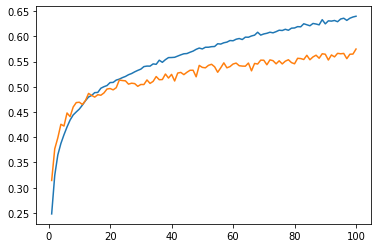

In [ ]:
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
print(train_accs)
print(test_accs)

plt.plot(range(1, 101), train_accs, range(1, 101), test_accs)